In [1]:
# CELL 1: Imports for whole notebook
import numpy as np
import pandas as pd
import s3fs

# Suppress warnings 
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Models, metrics, preprocessing, classifiers and stats 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Cell 2: Function to aggregate numerical data correspoding grouped by 'group_var'
# Use: Add new columns to training set from bureau, and bureau_balance.csv
def agg_numeric(df, group_var, df_name):
    # Drop columns that aren't being grouped
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group id and aggregate mean, max, min, count and sum
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Create new column names
    columns = [group_var]

    # Add new column names
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [3]:
# CELL 3: Count d  counts for categorial variable in groupvar
# Used on bureau and bureau_balance.csv
def count_categorical(df, group_var, df_name):
    
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Put id on col
    categorical[group_var] = df[group_var]

    # Groupby, calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            # New column names
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical



In [4]:
# Cell 4: Calculates counts of missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        # Calculate percent
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # table of missing values and percents
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        #Sort descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
                
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Cell 5: load files
fs = s3fs.S3FileSystem(anon=False)

with fs.open('home-credit-mb/application_train.csv') as f:
    train = pd.read_csv(f)
    
with fs.open('home-credit-mb/bureau.csv') as f:
    bureau = pd.read_csv(f)
    
with fs.open('home-credit-mb/bureau_balance.csv') as f:
    bureau_balance = pd.read_csv(f)
    
with fs.open('home-credit-mb/POS_CASH_balance.csv') as f:
    POS_CASH_balance = pd.read_csv(f)

In [ ]:
# 6) Run four below, get aggregations and categorical counts for bureau and bureau_balance

In [6]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

In [7]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')

In [8]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [9]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [10]:
# Cell 7) Creates data frame of loans stats for each client
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Include current SK_ID
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [11]:
# CELL 8)
# Aggregate stats in POS_CASH_BALANCE for each client
valid_IDs=train['SK_ID_CURR'].copy()
filteredPos = POS_CASH_balance.loc[POS_CASH_balance['SK_ID_CURR'].isin(valid_IDs)].sort_values(by=['SK_ID_CURR'])
POS_agg = agg_numeric(filteredPos, group_var = 'SK_ID_CURR', df_name = 'POS_CASH')

In [12]:
# CELL 9) merge new dataframes with train
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

train = train.merge(POS_agg, on='SK_ID_CURR', how = 'left')

In [13]:
# CELL 10) List missing values over 90%
missing_train = missing_values_table(train)
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])

In [14]:
# CELL 11) Read in test data, merge same bureau data
with fs.open('home-credit-mb/application_test.csv') as f:
    test = pd.read_csv(f)
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(POS_agg, on='SK_ID_CURR', how = 'left')


In [15]:
# CELL 12) 
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = train_labels

In [16]:
# CELL 13) Missing over 90% in test
missing_test = missing_values_table(test)
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])

In [17]:
# CELL 14) Drop columns with too much missing data
missing_columns = list(set(missing_test_vars + missing_train_vars))
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [18]:
# CELL 15) Calculate correlations
corrs = train.corr()
corrs = corrs.sort_values('TARGET', ascending = False)

In [20]:
# CELL 16) Get variables above threshold
threshold = 0.8

above_threshold_vars = {}

# Record variables above threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [21]:
# CELL 17) Get columns to remove, too colinear
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []


for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))


In [22]:
# CELL 18) Remove columns calculated above
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 204)
Testing Corrs Removed Shape:  (48744, 203)


In [23]:
# CELL 19) Imports needed to model, classify, and compute metrics

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import gc

import matplotlib.pyplot as plt

In [24]:
# CELL 20) Set up dataframes to test
test_xgb = test.copy()
train_xgb = train.copy()

train_ids = train_xgb['SK_ID_CURR']
test_ids = test_xgb['SK_ID_CURR']

# Training labels
labels = train_xgb['TARGET']

# Drops IDs and Targets
train_xgb = train_xgb.drop(columns = ['SK_ID_CURR', 'TARGET'])
test_xgb = test_xgb.drop(columns = ['SK_ID_CURR'])

In [26]:
# CELL 21) Encode, align and covert to numpy
train_xgb = pd.get_dummies(train_xgb)
test_xgb = pd.get_dummies(test_xgb)

train_xgb, test_xgb = train_xgb.align(test_xgb, join = 'inner', axis = 1)

train_xgb = np.array(train_xgb)
test_xgb = np.array(test_xgb)

In [27]:
# CELL 22) Create numpy zeros, lists for testing
test_predictions = np.zeros(test_xgb.shape[0])

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(train_xgb.shape[0])

# Lists for validation, training scores
valid_scores = []
train_scores = []

In [33]:
# CELL 23) Creates models, trains and calculates respective ROCS
%%time
n_folds = 3
k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

for train_indices, valid_indices in k_fold.split(train_xgb):
    
    # Training data for fold
    train_features, train_labels = train_xgb[train_indices], labels[train_indices]
    # Validation data for fold
    valid_features, valid_labels = train_xgb[valid_indices], labels[valid_indices]
    
    
    # Create model
    model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.15,
            max_depth = 12, alpha = 10, n_estimators = 50)
    
    # Train
    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              early_stopping_rounds = 100, verbose = True)
    
    # Out of fold predictions
    out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]
    
    # Clean memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

[0]	validation_0-auc:0.68074	validation_1-auc:0.71977
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.69717	validation_1-auc:0.75802
[2]	validation_0-auc:0.70158	validation_1-auc:0.78701
[3]	validation_0-auc:0.71621	validation_1-auc:0.81462
[4]	validation_0-auc:0.71770	validation_1-auc:0.82408
[5]	validation_0-auc:0.72264	validation_1-auc:0.83935
[6]	validation_0-auc:0.72497	validation_1-auc:0.84653
[7]	validation_0-auc:0.72908	validation_1-auc:0.85830
[8]	validation_0-auc:0.72691	validation_1-auc:0.87088
[9]	validation_0-auc:0.72891	validation_1-auc:0.87682
[10]	validation_0-auc:0.73052	validation_1-auc:0.88378
[11]	validation_0-auc:0.73042	validation_1-auc:0.88961
[12]	validation_0-auc:0.73229	validation_1-auc:0.89719
[13]	validation_0-auc:0.73544	validation_1-auc:0.90278
[14]	validation_0-auc:0.73604	validation_1-auc:0.90872
[15]	validation_0-auc:0.737

In [34]:
# CELL 24) Prints final ROC
from sklearn.metrics import roc_auc_score, roc_curve, auc 

#Calculate AUC:
print ('ROC AUC Score on the test dataset', roc_auc_score(labels, out_of_fold))

ROC AUC Score on the test dataset 0.7458579405576911


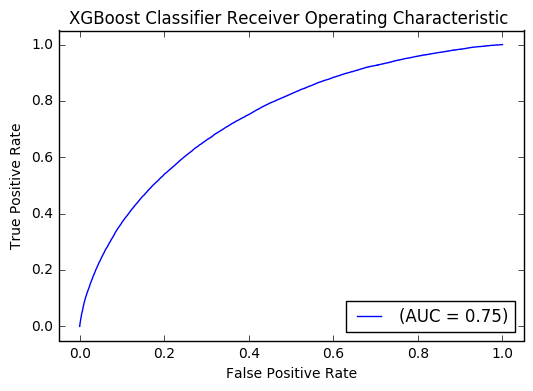

In [35]:
# CELL 25) Graphs ROC
fpr,tpr, thresholds= roc_curve(labels, out_of_fold) 
roc_auc=auc(fpr,tpr)


#Visual :https://www.kaggle.com/jomaxx/area-under-the-roc-curve-explained 
#fig, axs = plt.subplots(1, 2, figsize = (16,8))

#Plot ROC 
plt.plot(fpr, tpr, lw=1, label='(AUC = %0.2f)' % (roc_auc))

plt.title('XGBoost Classifier Receiver Operating Characteristic ')
plt.legend(loc="lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')